## Семинар 7: "Методы оптимизации"

ФИО: Токаева Александра

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class MyOptimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters: 
            if param.grad is not None:
                param.grad.zero_()      
  
    def step(self, F):
        loss = F()
        loss.backward()
        
class MySGD(MyOptimizer):
    def __init__(self,parameters,lr=0.01):
        super().__init__(parameters)
        self.lr=lr
        
    def step(self,F):
        loss = F()
        loss.backward()
        with torch.no_grad():
            for param in self.parameters:      
                param-=self.lr*param.grad  
                
class MyMomentum(MyOptimizer):
    def __init__(self,parameters,lr=0.01,gamma=0.9):
        super().__init__(parameters)
        self.lr=lr
        self.gamma=gamma
        self.vs=[torch.zeros_like(param) for param in self.parameters]
        
    def step(self,F):
        loss = F()
        loss.backward()
        with torch.no_grad():
            for param,v in zip(self.parameters,self.vs):  
                v.set_(self.gamma*v + self.lr*param.grad) #v_t = gamma*v_{t-1} +lr*grad
                param-=v 
                
                
class MyNesterov(MyOptimizer):
    def __init__(self,parameters,lr=0.01,gamma=0.9):
        super().__init__(parameters)
        self.lr=lr
        self.gamma=gamma
        self.vs=[torch.zeros_like(param) for param in self.parameters]
        
    def step(self,F):
        with torch.no_grad():
            for param,v in zip(self.parameters,self.vs):  
                param-=self.gamma*v
                
        loss = F()
        loss.backward()
        with torch.no_grad():
            for param,v in zip(self.parameters,self.vs):
                param+=self.gamma*v
                v.set_(self.gamma*v + self.lr*param.grad) #v_t = gamma*v_{t-1} +lr*grad
                param-=v 
  

        
class MyAdagrad(MyOptimizer):
    def __init__(self,parameters,lr=0.01,eps=1e-8):
        super().__init__(parameters)
        self.lr=lr
        self.eps=eps
        self.Gs=[torch.zeros_like(param) for param in self.parameters]
        
    def step(self,F):
        loss = F()
        loss.backward()
        with torch.no_grad():
            for param,G in zip(self.parameters,self.Gs):
                G+=param.grad**2
                param-=self.lr/(torch.sqrt(G+self.eps))*param.grad
                
class MyAdam(MyOptimizer):
    def __init__(self,parameters,lr=0.01,b1=0.9, b2=0.999, eps=1e-8):
        super().__init__(parameters)
        self.lr=lr
        self.b1=b1
        self.b2=b2
        self.eps=eps
        self.Ms=[torch.zeros_like(param) for param in self.parameters]
        self.Vs=[torch.zeros_like(param) for param in self.parameters]
        self.iterations=1
        
    def step(self,F):
        loss = F()
        loss.backward()
        with torch.no_grad():
            for param,m,v in zip(self.parameters,self.Ms,self.Vs):
                m.set_(self.b1*m+(1-self.b1)*param.grad)
                v.set_(self.b2*v+(1-self.b2)*param.grad**2)
                m_hat=m/(1-self.b1**self.iterations)
                v_hat=v/(1-self.b2**self.iterations)
                param-=self.lr/(torch.sqrt(v_hat+self.eps))*m_hat
                
        self.iterations+=1
        
class MyRMSProp(MyOptimizer):
    def __init__(self, parameters, lr=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.lr = lr
        self.gamma = gamma
        self.eps = 10e-9
        self.Gs= [torch.zeros_like(param) for param in self.parameters]
        
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param,G in zip(self.parameters,self.Gs):
                G.set_(self.gamma * G + (1 - self.gamma) * param.grad**2)
                
                param -= self.lr / torch.sqrt(G + self.eps) * param.grad
                
class MyAdadelta(MyOptimizer):
    def __init__(self, parameters, lr=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.lr = lr
        self.gamma = gamma
        self.eps = 10e-9
        self.Gs= [torch.zeros_like(param) for param in self.parameters]
        self.dThs= [torch.zeros_like(param) for param in self.parameters]
        
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param,G,dth in zip(self.parameters,self.Gs,self.dThs):
                G.set_(self.gamma * G + (1 - self.gamma) * param.grad**2)
                tek_delta= torch.sqrt(dth+self.eps)/ torch.sqrt(G + self.eps) * param.grad
                param -= tek_delta
                dth.set_(self.gamma * dth + (1 - self.gamma) * tek_delta**2)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

MySGD 8.30718454687537e-175
MyMomentum 0.0
MyNesterov 0.0
MyAdagrad 6.551827766733908
MyAdam 0.0
MyRMSProp 4.999500000000008e-05
MyAdadelta 5.721485610151056e-62


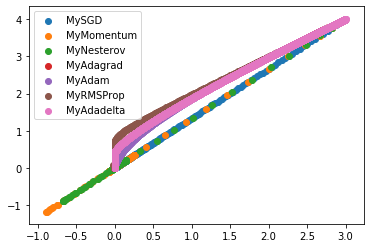

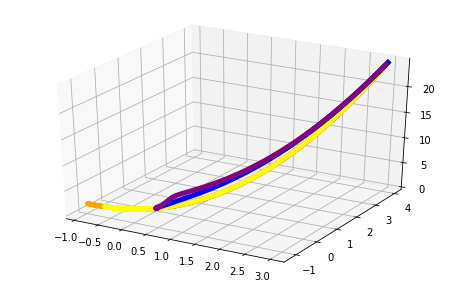

In [3]:
def J(x,y):
    return x**2+y**2

optimizers=[MySGD,MyMomentum,MyNesterov,MyAdagrad,MyAdam,MyRMSProp,MyAdadelta]
#optimizers=[MyMomentum]
RESULTS=[]

for optim in optimizers:
    v=torch.from_numpy(np.array([3,4],dtype=float))
    v.requires_grad=True
    opt=optim([v],lr=0.01)
    path=[]
    for i in range(10000):
        opt.zero_grad()
        opt.step(lambda v=v: J(v[0],v[1]))
        path.append((v.detach().numpy().copy()[0],v.detach().numpy().copy()[1],J(v[0],v[1]).detach().numpy().copy()))
        #print(J(v[0],v[1]))

    path=np.array(path)
    final_value=J(v[0],v[1])
    
    print(opt.__class__.__name__,final_value.item())
    
    RESULTS.append((final_value,path))

    
#plt.figure(figsize=(8,5))
for opt, (final_value,path) in zip(optimizers,RESULTS):
    plt.scatter(path[:,0],path[:,1],label=opt.__name__)

plt.legend()
plt.show()



from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

colors=['red','orange','yellow','green','blue','purple']

for color,path in zip(colors,RESULTS):
    points = np.array(path[1])
    #print(points)
    #points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)



plt.show()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

MySGD -48.16592044613666
MyMomentum -48.16592044613666
MyNesterov -48.16592044613666
MyAdagrad -16.017044919398025
MyAdam -48.16592044613666
MyRMSProp -48.16591303151175
MyAdadelta -48.165335850646194


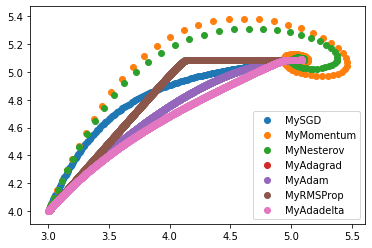

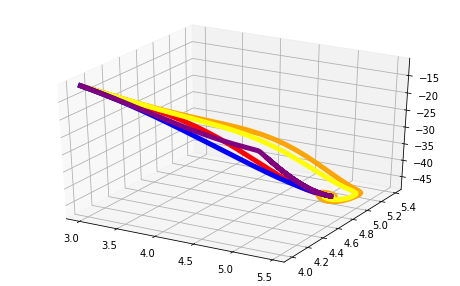

In [4]:
def J(x,y):
    return x**2*torch.sin(x)+y**2*torch.sin(y)


optimizers=[MySGD,MyMomentum,MyNesterov,MyAdagrad,MyAdam,MyRMSProp,MyAdadelta]
RESULTS=[]

for optim in optimizers:
    v=torch.from_numpy(np.array([3,4],dtype=float))
    v.requires_grad=True
    opt=optim([v],lr=0.001)
    path=[]
    for i in range(10000):
        opt.zero_grad()
        opt.step(lambda v=v: J(v[0],v[1]))
        path.append((v.detach().numpy().copy()[0],v.detach().numpy().copy()[1],J(v[0],v[1]).detach().numpy().copy()))
        

    path=np.array(path)
    final_value=J(v[0],v[1])
    
    print(opt.__class__.__name__,final_value.item())
    
    RESULTS.append((final_value,path))

    
#plt.figure(figsize=(8,5))
for opt, (final_value,path) in zip(optimizers,RESULTS):
    plt.scatter(path[:,0],path[:,1],label=opt.__name__)

plt.legend()
plt.show()


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

colors=['red','orange','yellow','green','blue','purple']

for color,path in zip(colors,RESULTS):
    points = np.array(path[1])
    #print(points)
    #points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)



plt.show()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

MySGD -28.348316623788513
MyMomentum -28.348316623788513
MyNesterov -28.348316623788513
MyAdagrad -4.305957199471715
MyAdam -28.348316623788513
MyRMSProp -28.348314491683716
MyAdadelta -28.328449181002064


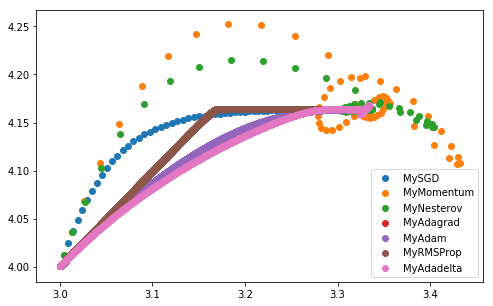

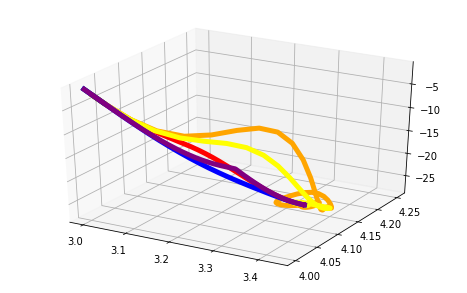

In [54]:
def J(x,y):
    return x**2*torch.sin(x**2)+y**2*torch.sin(y**2)


optimizers=[MySGD,MyMomentum,MyNesterov,MyAdagrad,MyAdam,MyRMSProp,MyAdadelta]
RESULTS=[]

for optim in optimizers:
    v=torch.from_numpy(np.array([3,4],dtype=float))
    v.requires_grad=True
    opt=optim([v],lr=0.0001)
    path=[]
    for i in range(10000):
        opt.zero_grad()
        opt.step(lambda v=v: J(v[0],v[1]))
        path.append((v.detach().numpy().copy()[0],v.detach().numpy().copy()[1],J(v[0],v[1]).detach().numpy().copy()))
        

    path=np.array(path)
    final_value=J(v[0],v[1])
    
    print(opt.__class__.__name__,final_value.item())
    
    RESULTS.append((final_value,path))

    
plt.figure(figsize=(8,5))

for opt, (final_value,path) in zip(optimizers,RESULTS):
    plt.scatter(path[:,0],path[:,1],label=opt.__name__)

plt.legend()
plt.show()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

colors=['red','orange','yellow','green','blue','purple']

for color,path in zip(colors,RESULTS):
    points = np.array(path[1])
    #print(points)
    #points += np.random.rand(3) * 0.04
    ax.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=5)



plt.show()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [1]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [19]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

images_train, labels_train = next(iter(train_loader))

In [21]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

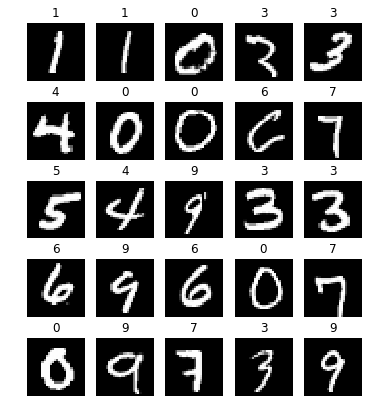

In [22]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [ ]:
Проверим, что вообще обучается:

In [29]:
from tqdm import tqdm
activation_func=torch.nn.Tanh
layers=[torch.nn.Linear(28*28,100), activation_func(), torch.nn.Linear(100,100), activation_func(), torch.nn.Linear(100,10)]

my_network=torch.nn.Sequential(*layers)

loss_neuron = torch.nn.NLLLoss()
optimizer=torch.optim.Adam(my_network.parameters(), lr=0.01)

mas_of_train_losses=[]

lgsfm = nn.LogSoftmax(dim=1)

for epoch in tqdm(range(2)):
    mas=[]
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        optimizer.zero_grad()
        #preds=my_network.forward(X)
        #tek_loss=loss_neuron.forward(preds,y)
        #mas.append(tek_loss.detach().numpy().copy())
        #tek_loss.backward()
        def myfunc(p=(X,y)):
            tek_otv=loss_neuron(lgsfm(my_network.forward(p[0])),p[1])
            mas.append(tek_otv.detach().numpy().copy())
            return tek_otv
        optimizer.step(myfunc)
        #optimizer.step(lambda p=(X,y): loss_neuron(lgsfm(my_network.forward(p[0])),p[1]))
    mas_of_train_losses.append(np.mean(mas))
    
mas_of_train_losses
    

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 11.61s/it]


[2.3299682, 2.329967]

In [ ]:
Обучим:

In [30]:
def train(my_network, myoptim,epochs=2, learning_rate=0.01):
    loss_neuron = torch.nn.NLLLoss()
    optimizer = myoptim(my_network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in tqdm(train_loader):
                X = X.view(X.shape[0], -1)
                optimizer.zero_grad()
                def myfunc(p=(X,y)):
                    preds=my_network.forward(p[0])
                    tek_otv=loss_neuron(lgsfm(preds),p[1])
                    losses.append(tek_otv.detach().numpy().copy())
                    mask=(np.argmax(preds.detach().numpy().copy(), axis=1)==y.detach().numpy().copy()).astype(int)
                    accuracies.append(mask.mean())
                    return tek_otv
                optimizer.step(myfunc)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            
            losses = []
            #accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1)
                preds=my_network.forward(X)
                tek_otv=loss_neuron(lgsfm(preds),y)
                losses.append(tek_otv.detach().numpy().copy())
                mask=(np.argmax(preds.detach().numpy().copy(), axis=1)==y.detach().numpy().copy()).astype(int)
                accuracies.append(mask.mean())
            
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            #clear_output(True)
            print('\rEpoch {0}... NLLLoss(Train/Test): {1:.3f}/{2:.3f} Accuracy(Train/Test): {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            
            
            
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 1, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 46.49it/s]


Epoch 0... NLLLoss(Train/Test): 0.525/0.273 Accuracy(Train/Test): 0.870/0.877


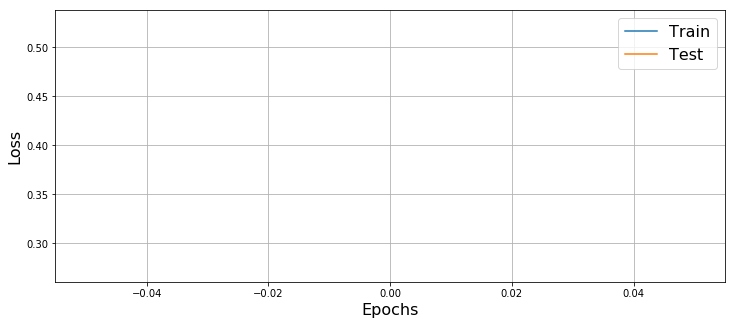

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.10it/s]


Epoch 1... NLLLoss(Train/Test): 0.241/0.205 Accuracy(Train/Test): 0.930/0.931


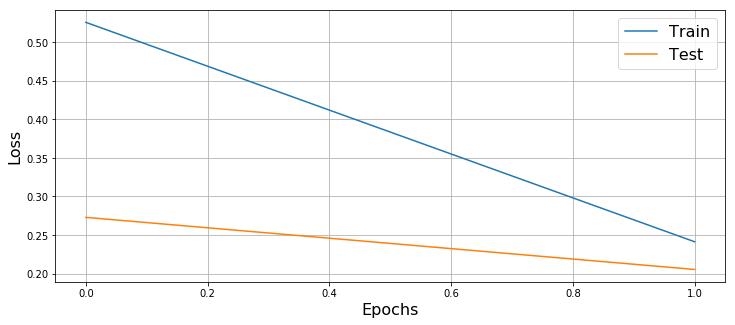

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.95it/s]


Epoch 2... NLLLoss(Train/Test): 0.184/0.166 Accuracy(Train/Test): 0.948/0.948


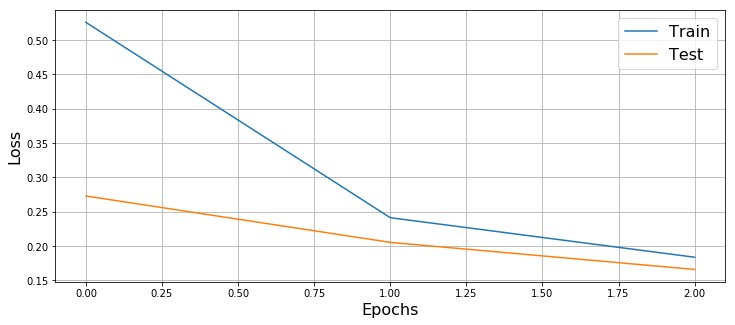

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.04it/s]


Epoch 3... NLLLoss(Train/Test): 0.148/0.138 Accuracy(Train/Test): 0.958/0.958


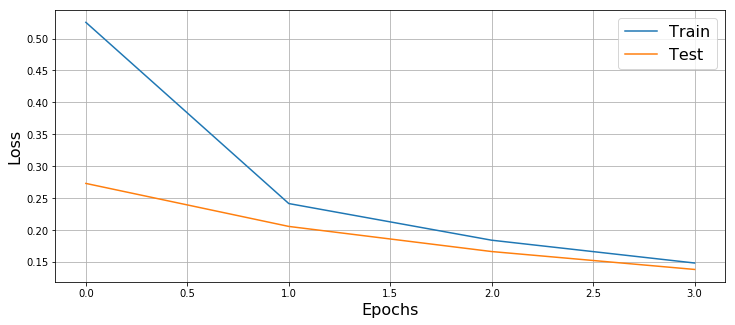

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.32it/s]


Epoch 4... NLLLoss(Train/Test): 0.123/0.124 Accuracy(Train/Test): 0.965/0.965


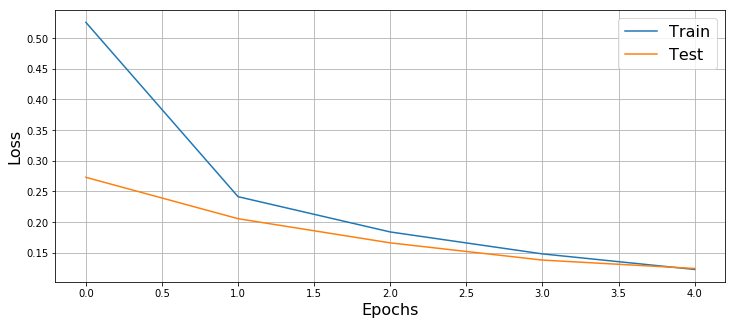

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 42.17it/s]


Epoch 5... NLLLoss(Train/Test): 0.104/0.111 Accuracy(Train/Test): 0.971/0.970


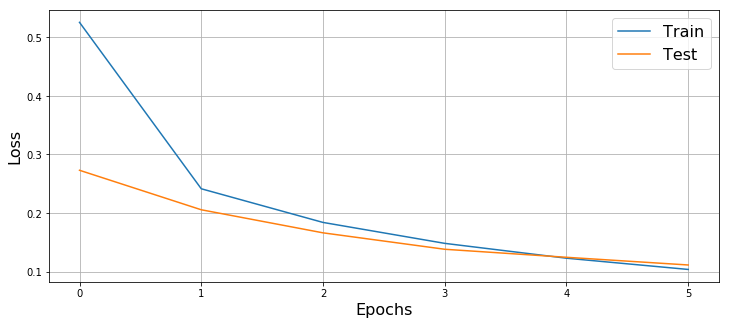

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.97it/s]


Epoch 6... NLLLoss(Train/Test): 0.089/0.107 Accuracy(Train/Test): 0.975/0.974


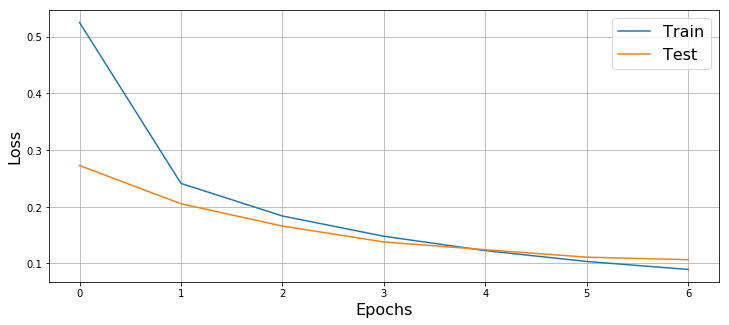

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.30it/s]


Epoch 7... NLLLoss(Train/Test): 0.078/0.097 Accuracy(Train/Test): 0.978/0.977


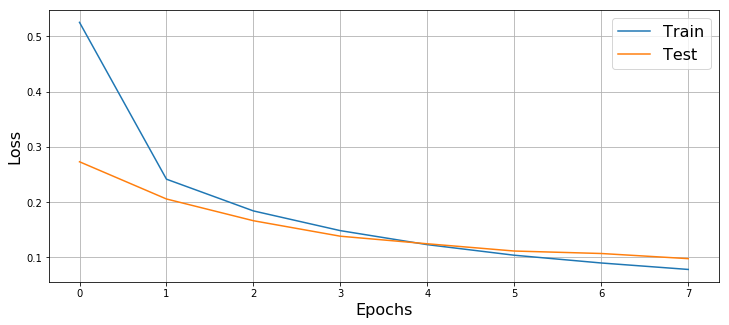

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.76it/s]


Epoch 8... NLLLoss(Train/Test): 0.069/0.091 Accuracy(Train/Test): 0.981/0.980


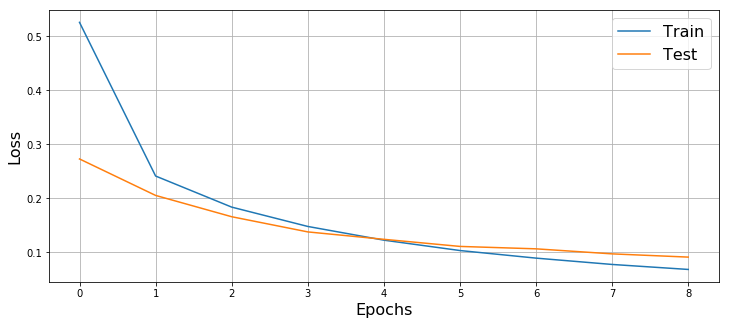

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.18it/s]


Epoch 9... NLLLoss(Train/Test): 0.060/0.086 Accuracy(Train/Test): 0.984/0.983


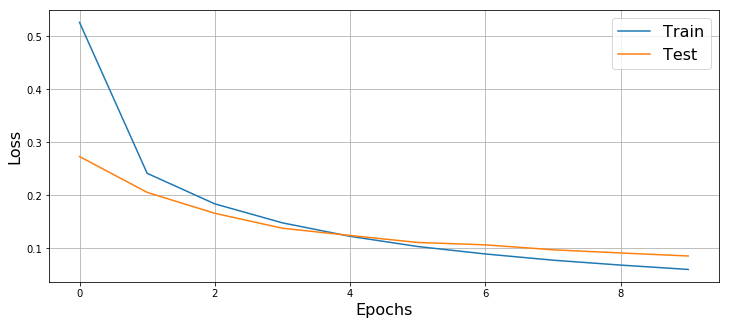

Wall time: 2min 3s


In [33]:
activation_func=torch.nn.Tanh
layers=[torch.nn.Linear(28*28,100), activation_func(), torch.nn.Linear(100,100), activation_func(), torch.nn.Linear(100,10)]

my_network1=torch.nn.Sequential(*layers)

%time train(my_network1,MySGD,epochs=10, learning_rate=0.05)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 46.48it/s]


Epoch 0... NLLLoss(Train/Test): 0.118/0.105 Accuracy(Train/Test): 0.963/0.964


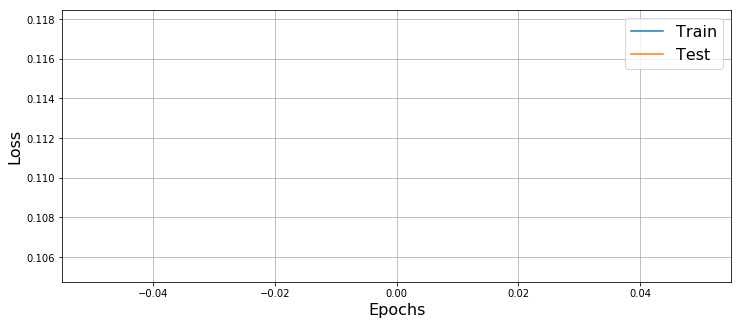

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.53it/s]


Epoch 1... NLLLoss(Train/Test): 0.076/0.106 Accuracy(Train/Test): 0.976/0.975


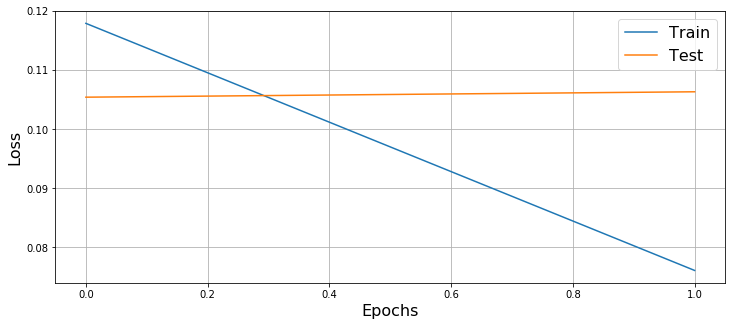

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.30it/s]


Epoch 2... NLLLoss(Train/Test): 0.059/0.096 Accuracy(Train/Test): 0.981/0.979


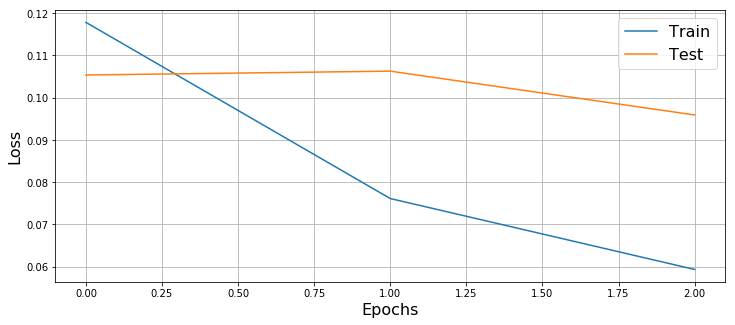

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.02it/s]


Epoch 3... NLLLoss(Train/Test): 0.046/0.095 Accuracy(Train/Test): 0.985/0.983


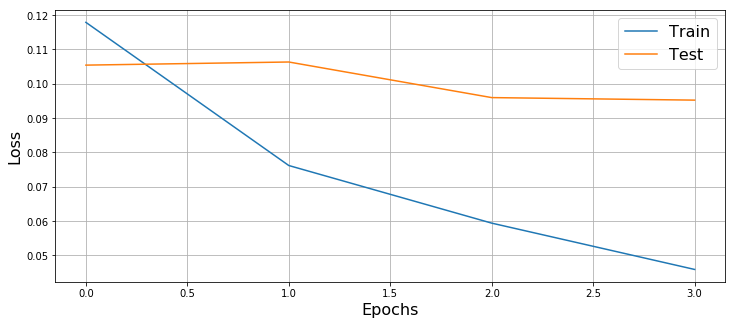

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.64it/s]


Epoch 4... NLLLoss(Train/Test): 0.038/0.089 Accuracy(Train/Test): 0.987/0.986


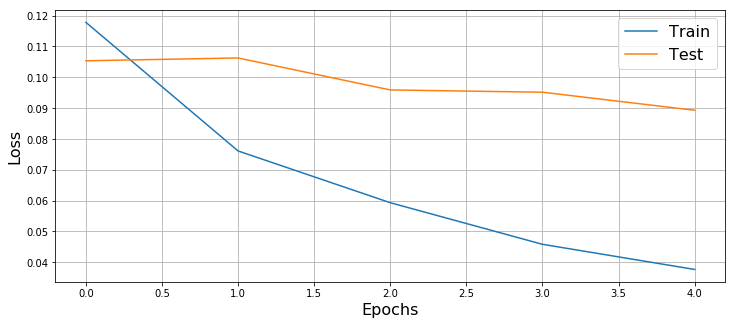

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.51it/s]


Epoch 5... NLLLoss(Train/Test): 0.027/0.096 Accuracy(Train/Test): 0.991/0.988


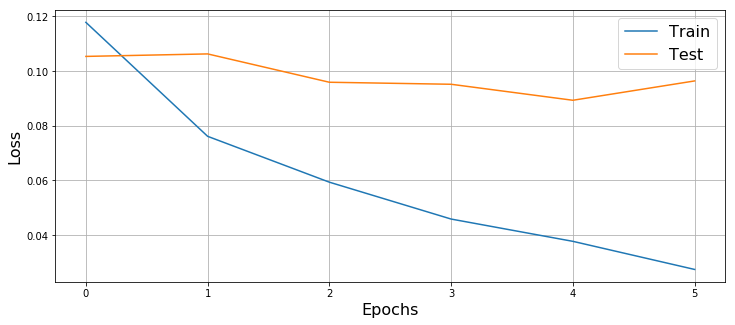

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.89it/s]


Epoch 6... NLLLoss(Train/Test): 0.021/0.098 Accuracy(Train/Test): 0.994/0.991


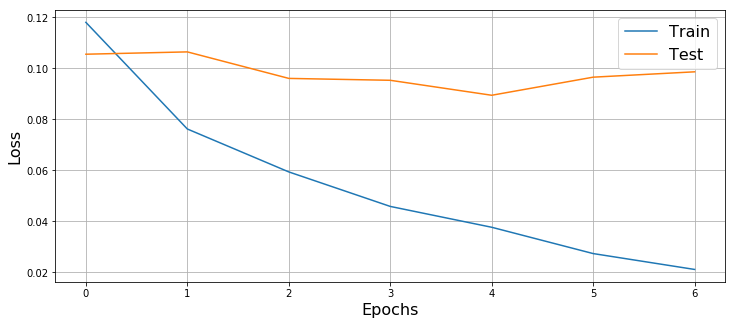

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 17.52it/s]


Epoch 7... NLLLoss(Train/Test): 0.016/0.088 Accuracy(Train/Test): 0.995/0.992


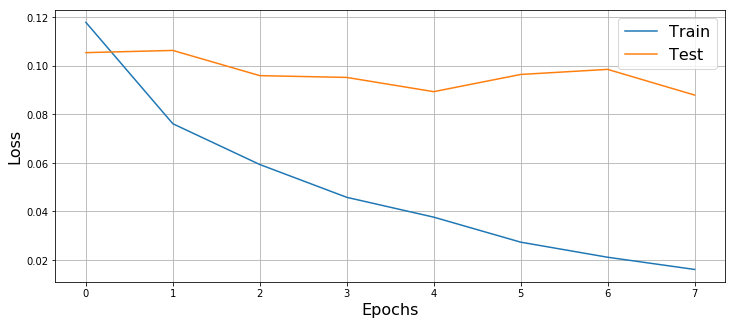

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.89it/s]


Epoch 8... NLLLoss(Train/Test): 0.014/0.089 Accuracy(Train/Test): 0.995/0.993


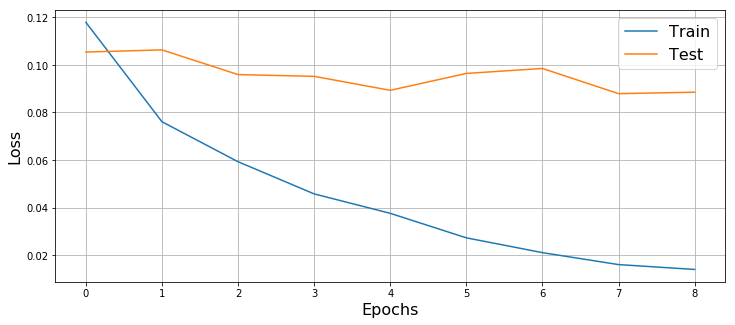

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.67it/s]


Epoch 9... NLLLoss(Train/Test): 0.014/0.095 Accuracy(Train/Test): 0.996/0.993


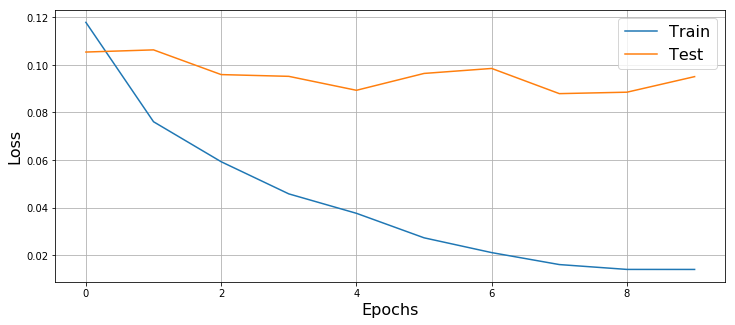

Wall time: 2min 54s


In [35]:
my_network2=torch.nn.Sequential(*layers)
%time train(my_network2,MyMomentum,epochs=10, learning_rate=0.05)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.40it/s]


Epoch 0... NLLLoss(Train/Test): 0.008/0.094 Accuracy(Train/Test): 0.998/0.995


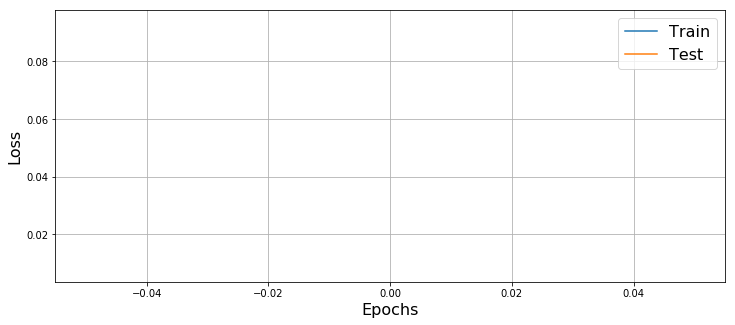

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.64it/s]


Epoch 1... NLLLoss(Train/Test): 0.004/0.095 Accuracy(Train/Test): 0.999/0.996


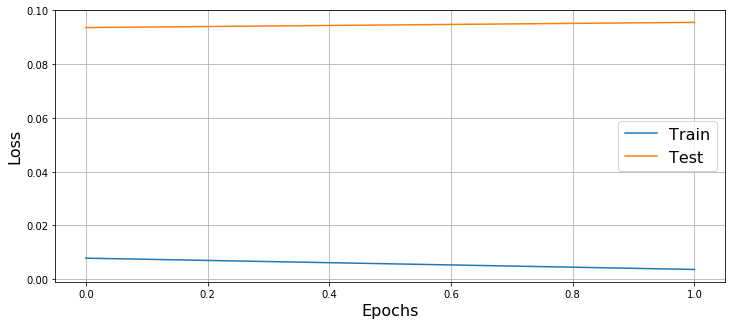

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 16.18it/s]


Epoch 2... NLLLoss(Train/Test): 0.002/0.091 Accuracy(Train/Test): 1.000/0.997


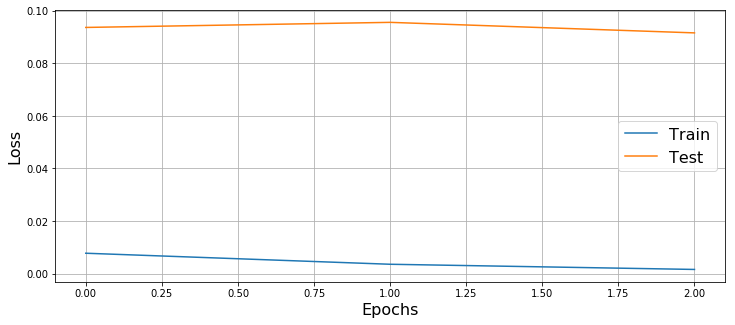

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 3... NLLLoss(Train/Test): 0.001/0.097 Accuracy(Train/Test): 1.000/0.997


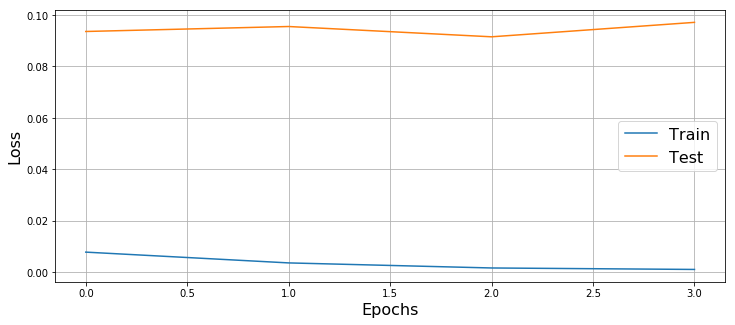

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.39it/s]


Epoch 4... NLLLoss(Train/Test): 0.001/0.091 Accuracy(Train/Test): 1.000/0.997


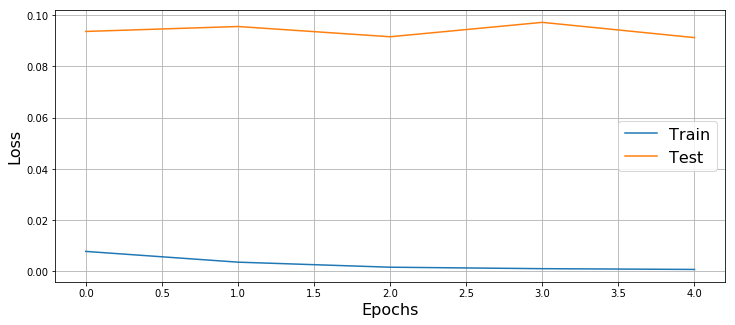

Wall time: 2min 28s


In [37]:
my_network3=torch.nn.Sequential(*layers)
%time train(my_network3,MyNesterov,epochs=5, learning_rate=0.05)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.32it/s]


Epoch 0... NLLLoss(Train/Test): 0.334/0.140 Accuracy(Train/Test): 0.920/0.925


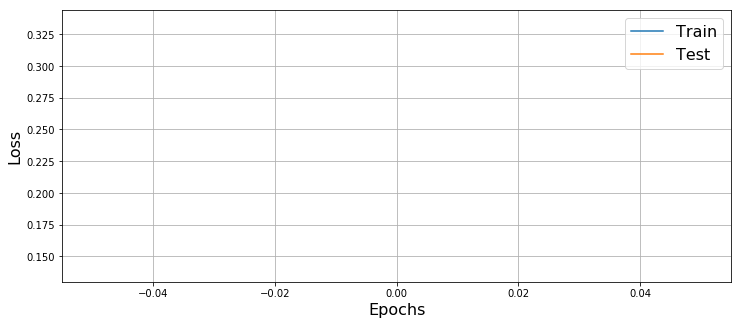

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.74it/s]


Epoch 1... NLLLoss(Train/Test): 0.111/0.122 Accuracy(Train/Test): 0.965/0.965


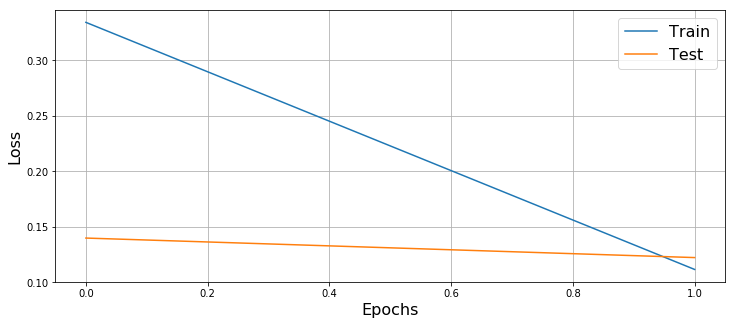

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.12it/s]


Epoch 2... NLLLoss(Train/Test): 0.081/0.111 Accuracy(Train/Test): 0.975/0.974


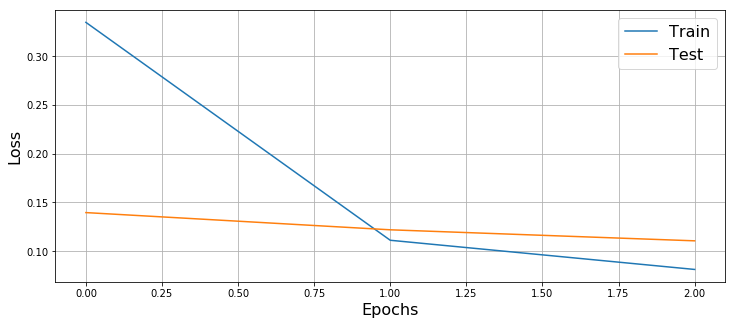

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.67it/s]


Epoch 3... NLLLoss(Train/Test): 0.063/0.105 Accuracy(Train/Test): 0.981/0.978


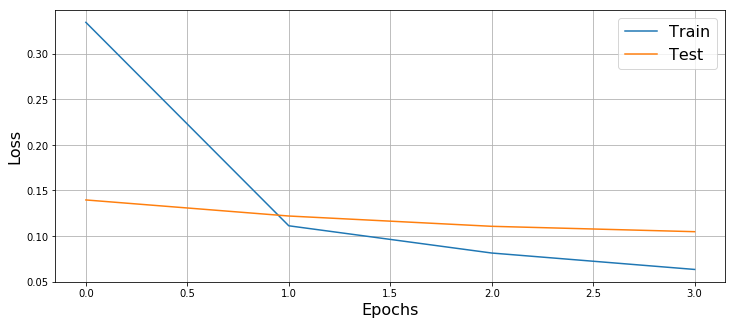

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 18.76it/s]


Epoch 4... NLLLoss(Train/Test): 0.050/0.104 Accuracy(Train/Test): 0.985/0.982


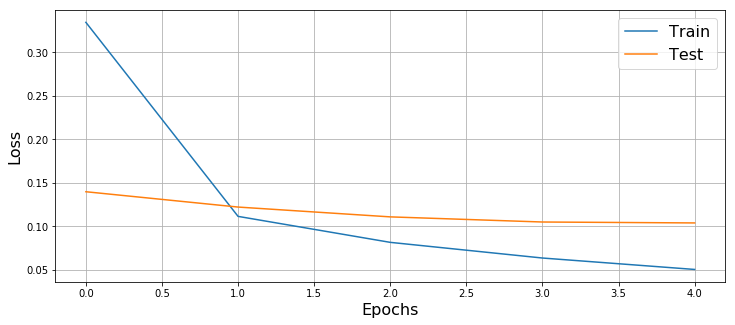

Wall time: 2min 26s


In [38]:
my_network4=torch.nn.Sequential(*layers)
%time train(my_network4,MyAdagrad,epochs=5, learning_rate=0.05)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:26<00:00, 17.57it/s]


Epoch 0... NLLLoss(Train/Test): 0.883/0.986 Accuracy(Train/Test): 0.735/0.729


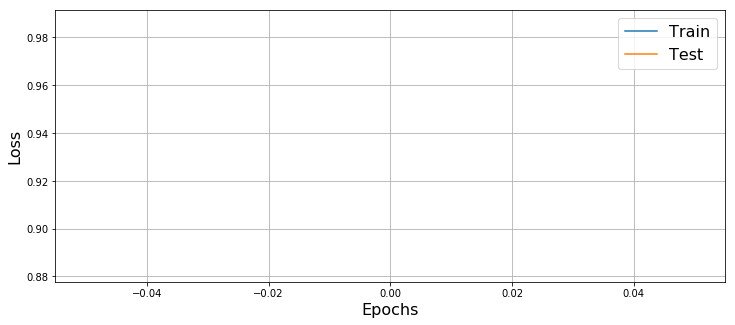

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.13it/s]


Epoch 1... NLLLoss(Train/Test): 0.939/0.961 Accuracy(Train/Test): 0.705/0.706


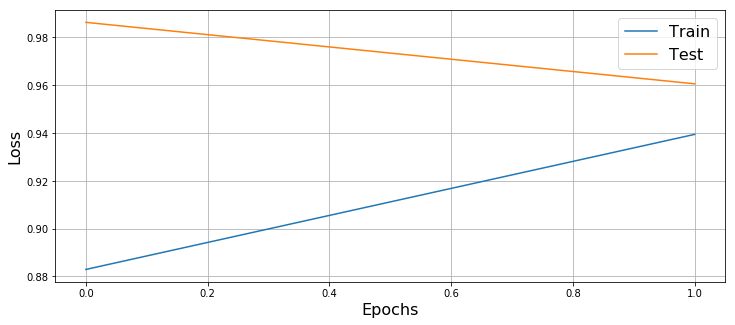

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 18.97it/s]


Epoch 2... NLLLoss(Train/Test): 0.970/0.908 Accuracy(Train/Test): 0.695/0.698


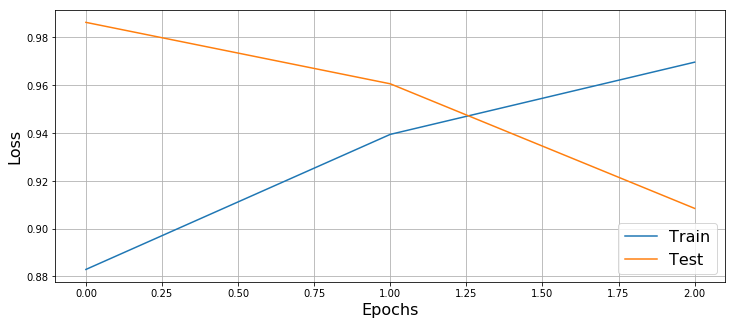

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.29it/s]


Epoch 3... NLLLoss(Train/Test): 0.919/0.866 Accuracy(Train/Test): 0.711/0.714


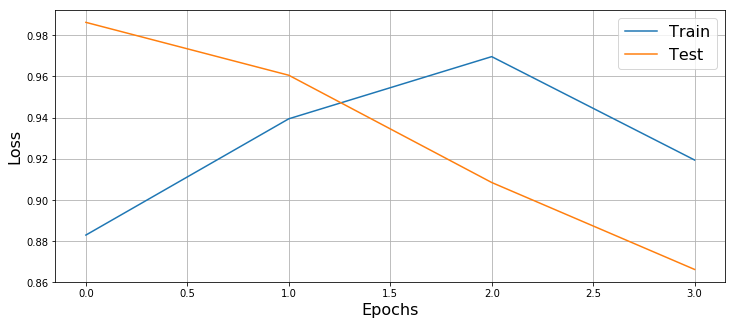

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 17.34it/s]


Epoch 4... NLLLoss(Train/Test): 0.943/0.944 Accuracy(Train/Test): 0.707/0.708


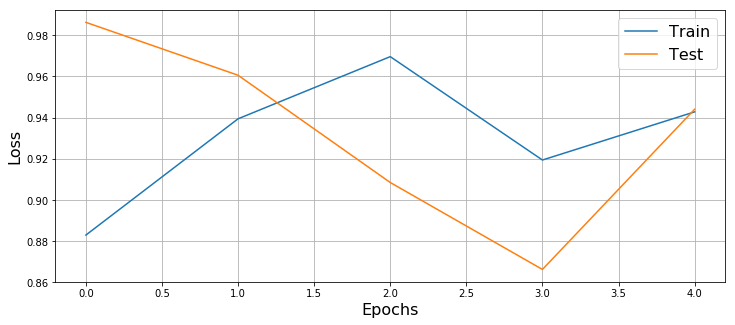

Wall time: 2min 28s


In [39]:
my_network5=torch.nn.Sequential(*layers)
%time train(my_network5,MyAdam,epochs=5, learning_rate=0.05)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.34it/s]


Epoch 0... NLLLoss(Train/Test): 1.623/0.972 Accuracy(Train/Test): 0.689/0.702


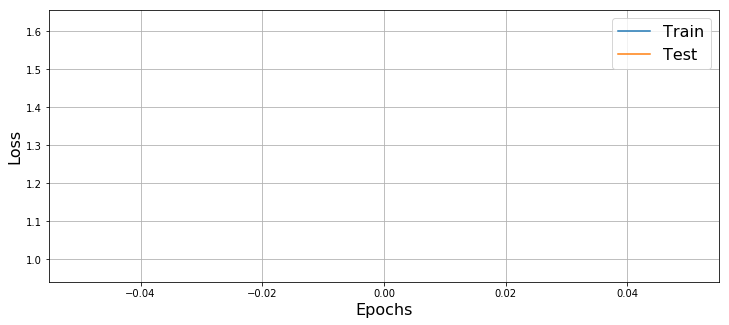

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 18.78it/s]


Epoch 1... NLLLoss(Train/Test): 1.286/1.410 Accuracy(Train/Test): 0.749/0.743


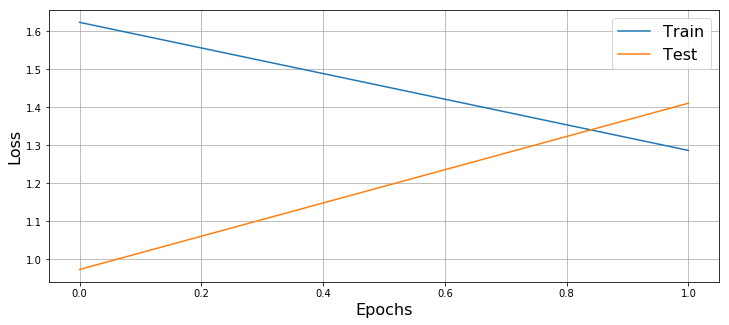

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.22it/s]


Epoch 2... NLLLoss(Train/Test): 1.197/1.731 Accuracy(Train/Test): 0.771/0.764


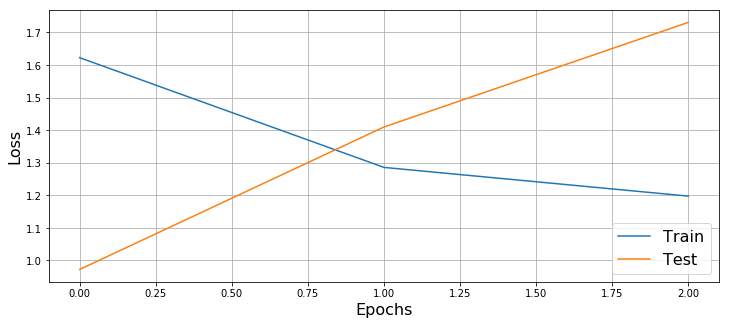

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.03it/s]


Epoch 3... NLLLoss(Train/Test): 1.127/1.104 Accuracy(Train/Test): 0.784/0.783


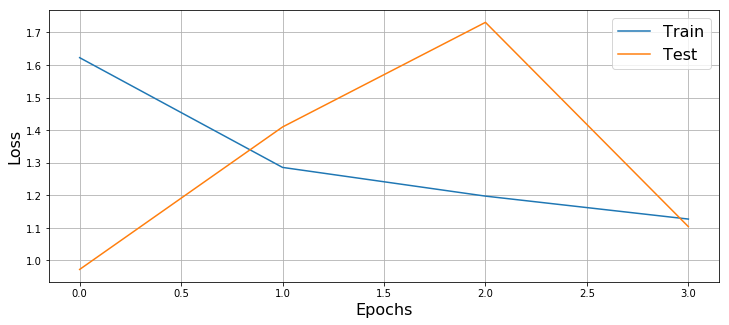

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.52it/s]


Epoch 4... NLLLoss(Train/Test): 1.048/1.088 Accuracy(Train/Test): 0.799/0.796


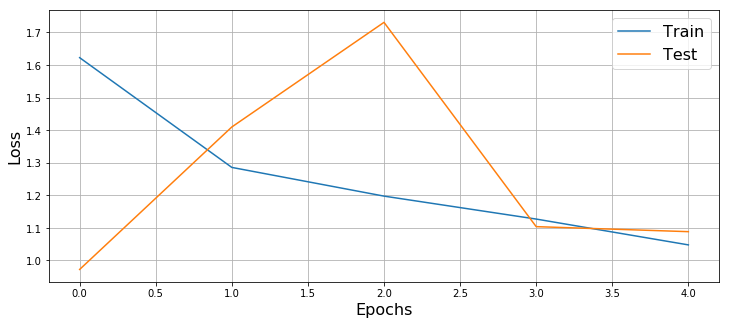

Wall time: 2min 24s


In [40]:
my_network6=torch.nn.Sequential(*layers)
%time train(my_network6,MyRMSProp,epochs=5, learning_rate=0.05)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.61it/s]


Epoch 0... NLLLoss(Train/Test): 0.479/0.462 Accuracy(Train/Test): 0.881/0.881


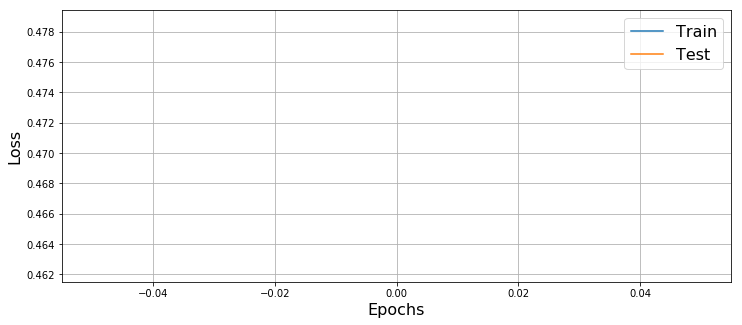

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.75it/s]


Epoch 1... NLLLoss(Train/Test): 0.466/0.460 Accuracy(Train/Test): 0.881/0.882


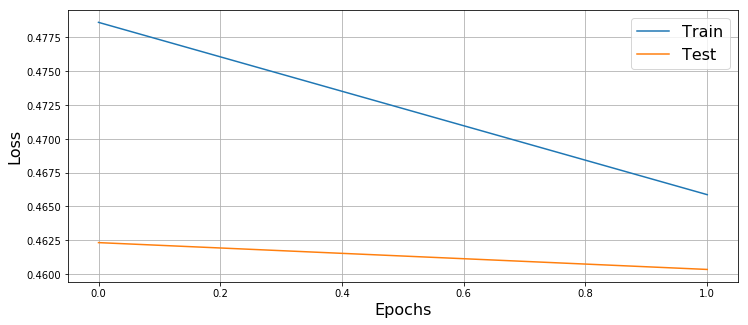

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.30it/s]


Epoch 2... NLLLoss(Train/Test): 0.455/0.447 Accuracy(Train/Test): 0.882/0.883


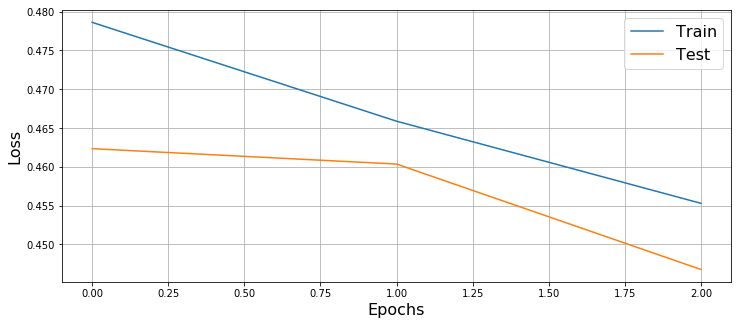

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.00it/s]


Epoch 3... NLLLoss(Train/Test): 0.447/0.438 Accuracy(Train/Test): 0.883/0.883


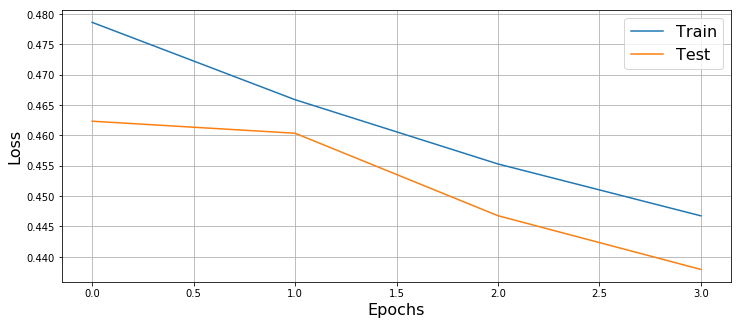

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 42.75it/s]


Epoch 4... NLLLoss(Train/Test): 0.439/0.432 Accuracy(Train/Test): 0.883/0.884


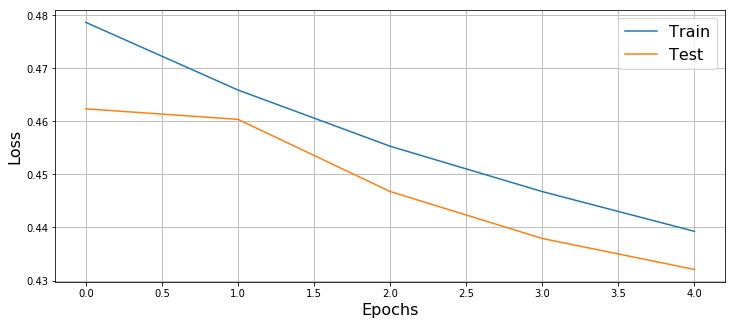

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.27it/s]


Epoch 5... NLLLoss(Train/Test): 0.433/0.427 Accuracy(Train/Test): 0.884/0.885


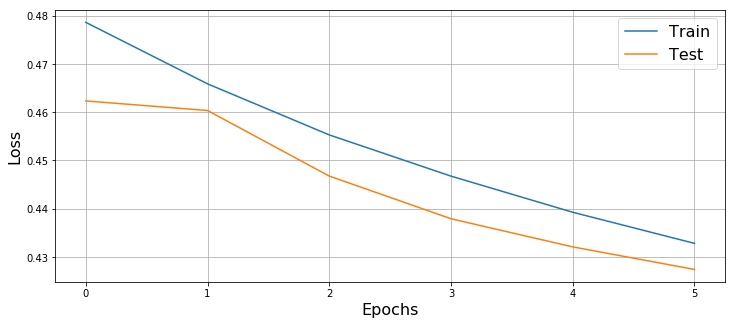

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.11it/s]


Epoch 6... NLLLoss(Train/Test): 0.428/0.424 Accuracy(Train/Test): 0.885/0.885


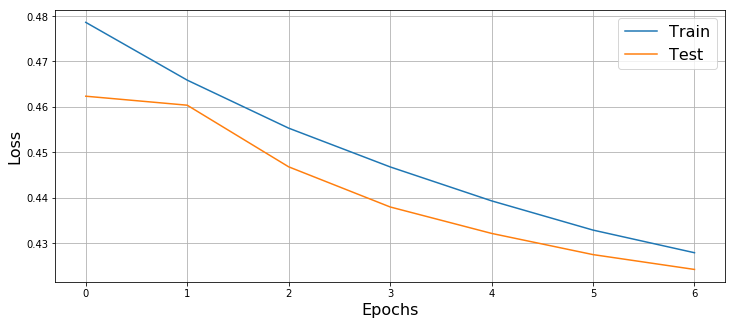

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.36it/s]


Epoch 7... NLLLoss(Train/Test): 0.423/0.425 Accuracy(Train/Test): 0.885/0.885


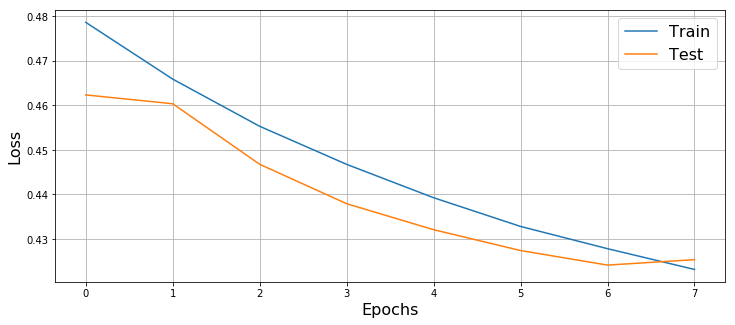

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.59it/s]


Epoch 8... NLLLoss(Train/Test): 0.419/0.425 Accuracy(Train/Test): 0.886/0.886


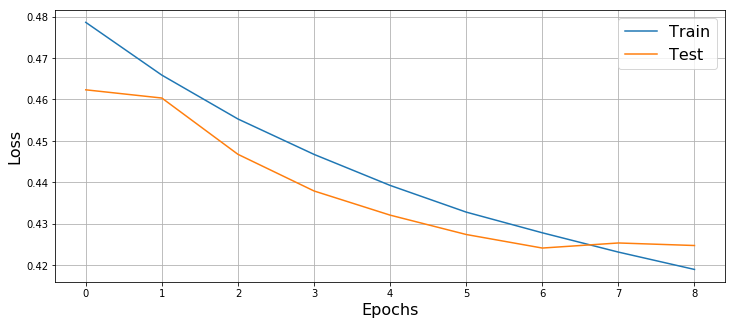

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 35.65it/s]


Epoch 9... NLLLoss(Train/Test): 0.415/0.417 Accuracy(Train/Test): 0.887/0.887


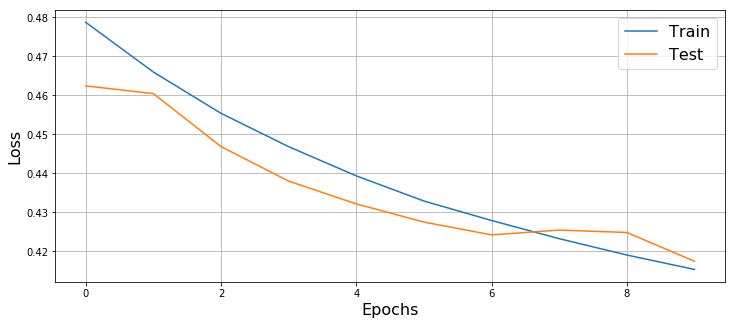

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.04it/s]


Epoch 10... NLLLoss(Train/Test): 0.412/0.413 Accuracy(Train/Test): 0.887/0.887


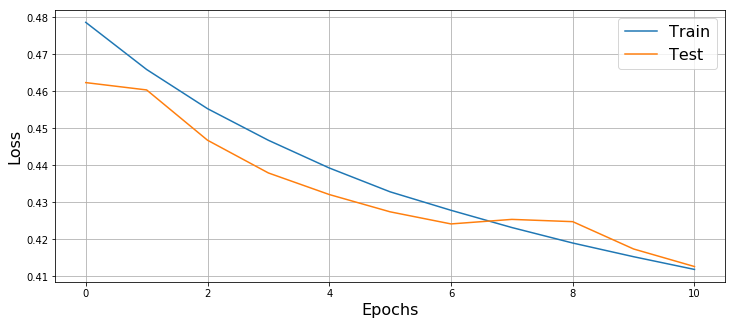

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.67it/s]


Epoch 11... NLLLoss(Train/Test): 0.409/0.410 Accuracy(Train/Test): 0.888/0.888


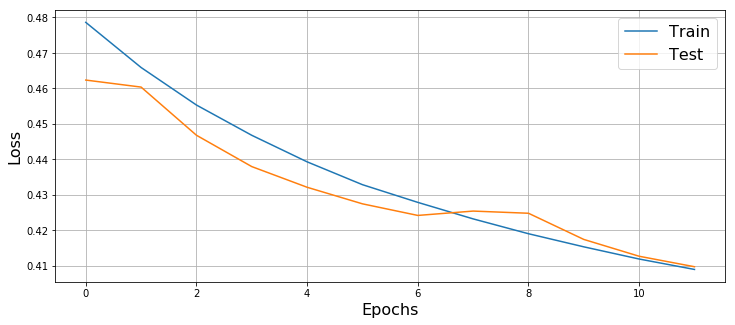

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.86it/s]


Epoch 12... NLLLoss(Train/Test): 0.407/0.411 Accuracy(Train/Test): 0.888/0.888


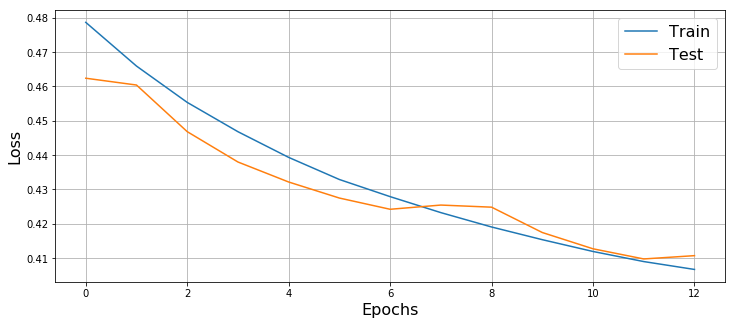

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.00it/s]


Epoch 13... NLLLoss(Train/Test): 0.404/0.412 Accuracy(Train/Test): 0.888/0.889


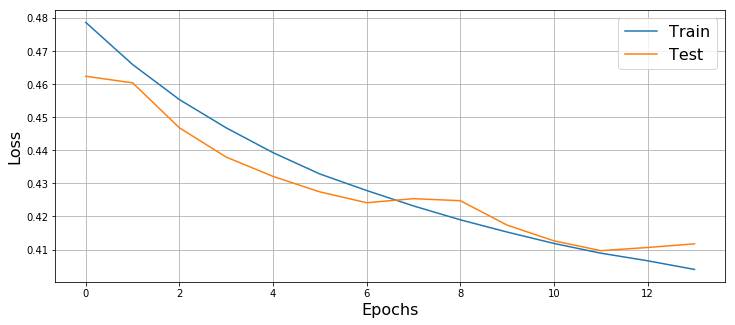

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.20it/s]


Epoch 14... NLLLoss(Train/Test): 0.402/0.408 Accuracy(Train/Test): 0.889/0.889


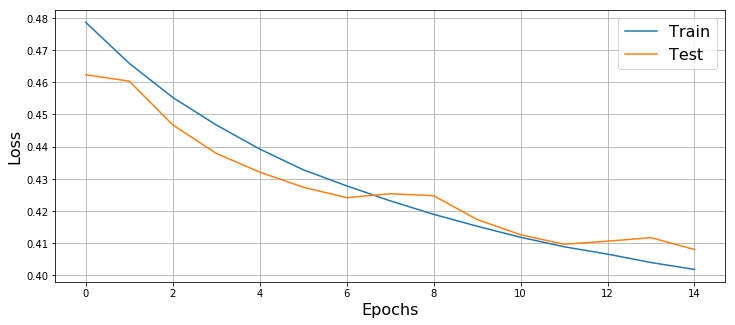

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.12it/s]


Epoch 15... NLLLoss(Train/Test): 0.400/0.409 Accuracy(Train/Test): 0.889/0.889


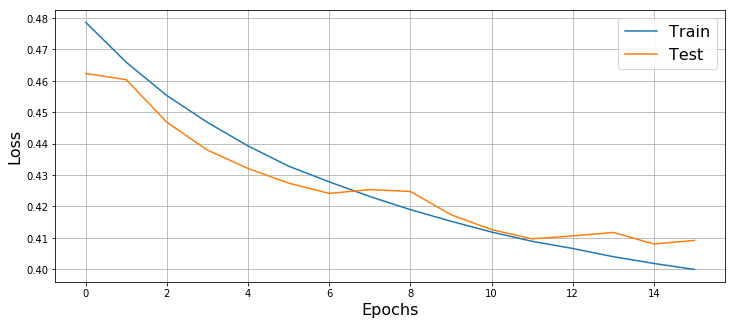

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.74it/s]


Epoch 16... NLLLoss(Train/Test): 0.398/0.404 Accuracy(Train/Test): 0.889/0.889


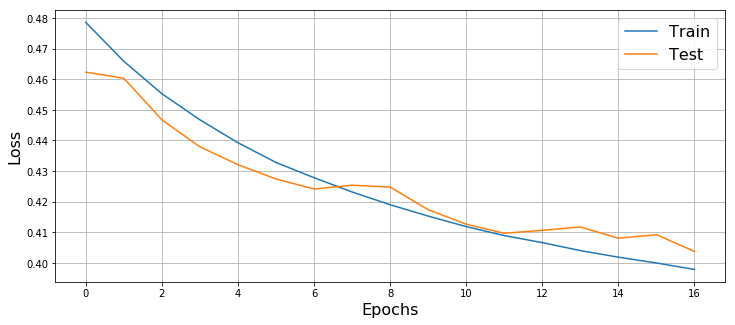

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 42.77it/s]


Epoch 17... NLLLoss(Train/Test): 0.397/0.403 Accuracy(Train/Test): 0.890/0.890


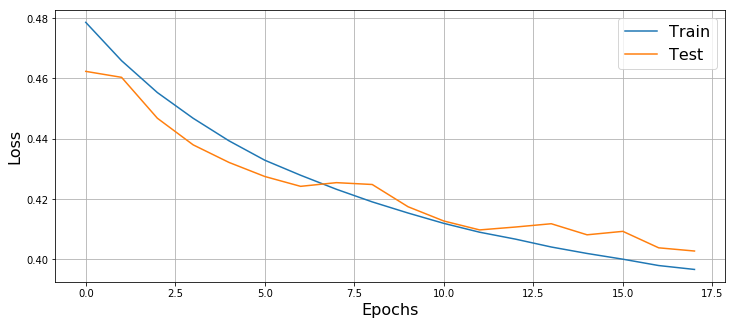

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.57it/s]


Epoch 18... NLLLoss(Train/Test): 0.395/0.401 Accuracy(Train/Test): 0.890/0.890


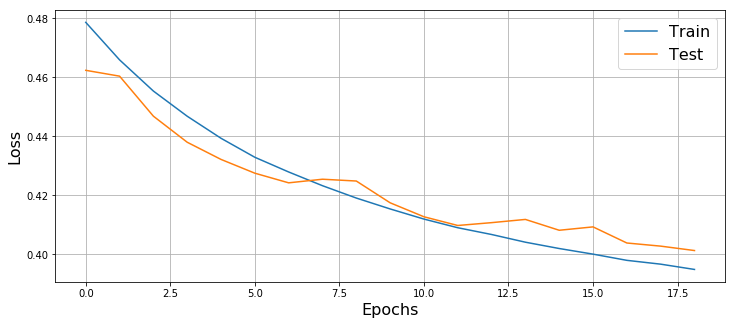

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 42.15it/s]


Epoch 19... NLLLoss(Train/Test): 0.393/0.397 Accuracy(Train/Test): 0.890/0.891


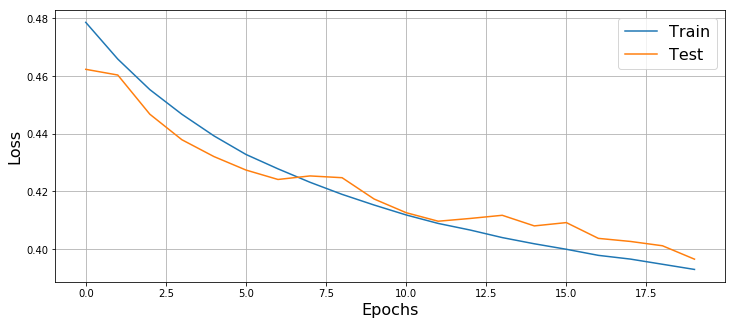

Wall time: 4min 10s


In [56]:
my_network7=torch.nn.Sequential(*layers)
%time train(my_network7,MyAdadelta,epochs=20, learning_rate=0.05)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: